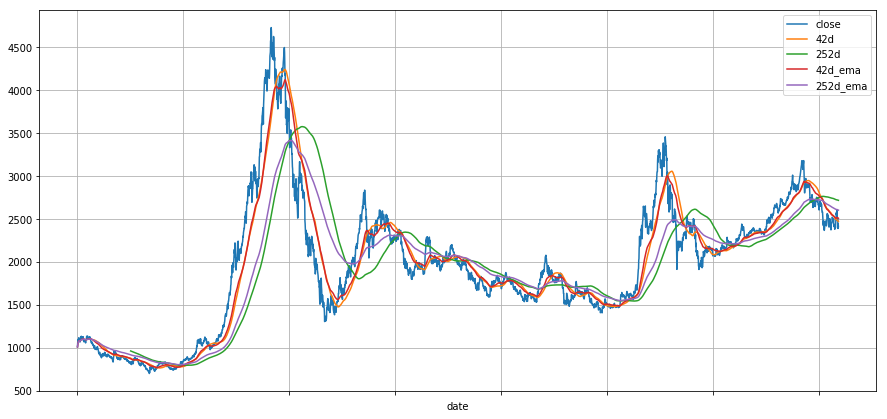

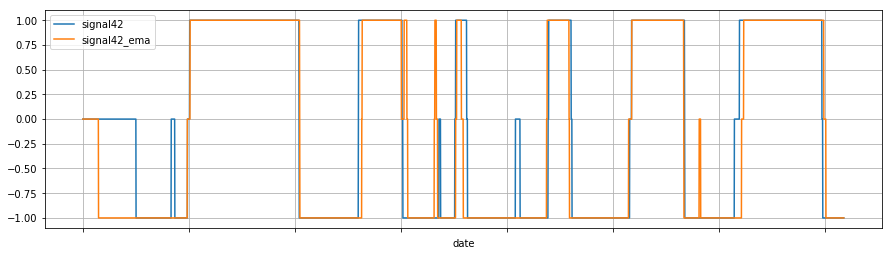

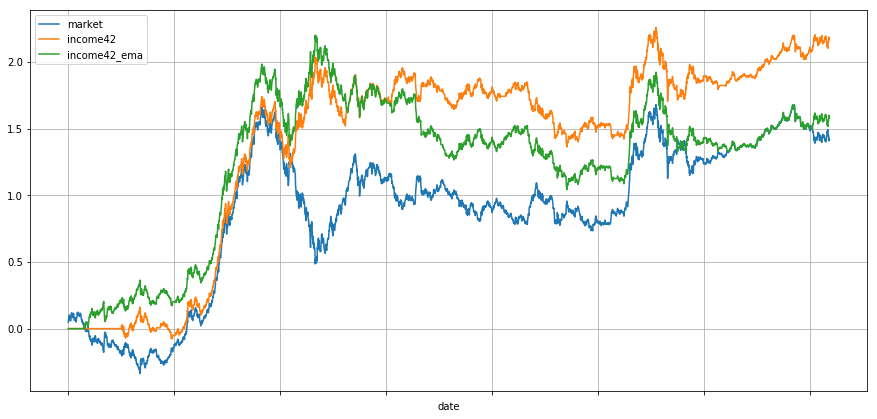

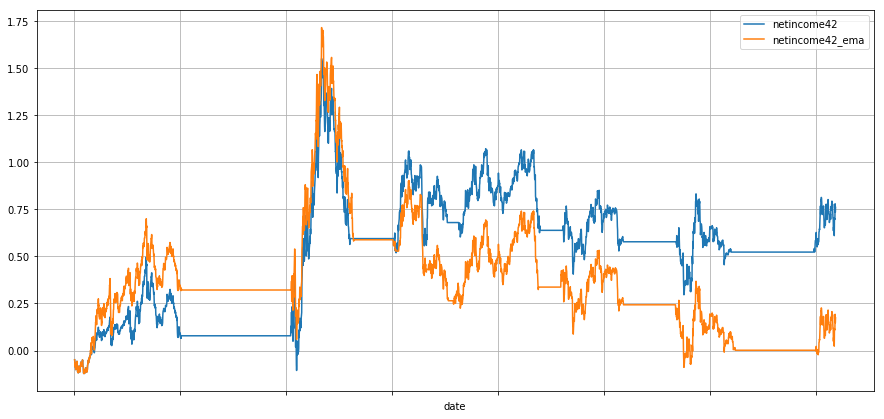

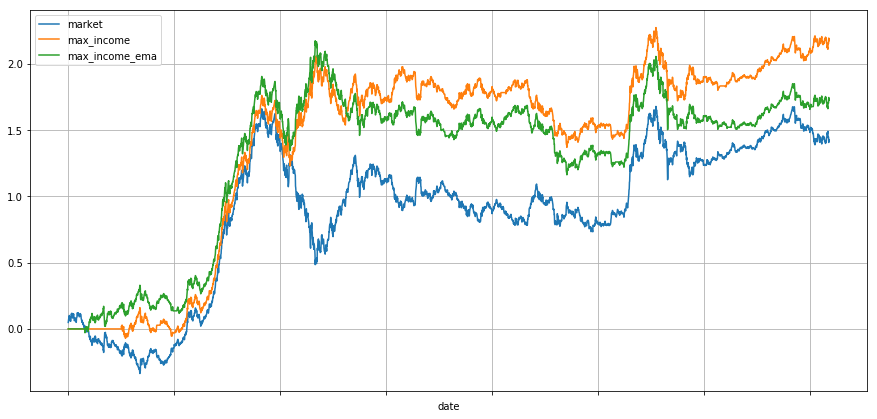

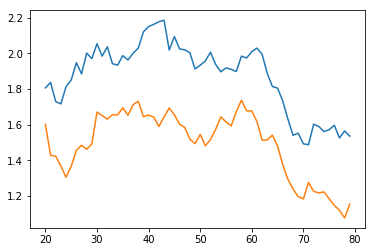

Best period1 for Rolling_Mean= 43
Best period1 for EWMA= 58


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts

sz50 = ts.get_k_data('sz50',start='2004-01-01')
#通过网络获取上证指数的历史数据,通过info方法查看数据的基本信息
sz50 = sz50.set_index('date')

periods1 = list(range(60))
min_period = 20
x = []
y = []
y_ema = []
max_accu_income = 0
max_accu_income_ema = 0
for period1 in periods1:
    x.append(period1+min_period)
    #实现两个趋势策略,期间指数水平移动平均数,分别是两个月(42天),一年(252天).一年只有252个交易日
    sz50['42d'] = np.round(sz50['close'].rolling(window= period1+min_period).mean(), 2)
    sz50['42d_ema'] = np.round(sz50['close'].ewm(span= period1+min_period).mean(), 5)
    sz50['252d'] = np.round(sz50['close'].rolling(window= 252).mean(), 2)
    sz50['252d_ema'] = np.round(sz50['close'].ewm(span= 252).mean(), 5)
    sz50.tail()

    #基于这些数据,可以设计一些规则来生简单的成趋势信号
    # 卖出信号
    # 42天平均线第一次高于252天平均线SD(平均值差值的阈值)点
    # 等待(持币)
    # 42天平均线在252天平均线的+-SD点范围内
    # 买入信号
    #在sz50上添加一个新的列,两个平均数据的差值,'42-252',因为两个均值的区间不同,所以数量上是不相等的,缺失的部分为Nan
    sz50['42-252'] = sz50['42d'] - sz50['252d']
    sz50['42-252_ema'] = sz50['42d_ema'] - sz50['252d_ema']
    sz50[['close','42d','252d','42-252','42d_ema','252d_ema','42-252_ema']].head()
    sz50[['close','42d','252d','42-252','42d_ema','252d_ema','42-252_ema']].tail()

    # 设置信号阈值SD,增加一个新列signal
    # np.where(condition,x,y)有三个参数,第一个为判断条件,也可为bool,
    # 条件为真时返回x,否则y
    # 官方文档中np.where跟详细的介绍:https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    SD = 10
    sz50['signal'] = np.where(sz50['42-252'] > SD, 1, 0)
    sz50['signal'] = np.where(sz50['42-252'] < -SD, -1, sz50['signal'])
    sz50['signal'].value_counts()
    sz50['signal_ema'] = np.where(sz50['42-252_ema'] > SD, 1, 0)
    sz50['signal_ema'] = np.where(sz50['42-252_ema'] < -SD, -1, sz50['signal_ema'])
    sz50['signal_ema'].value_counts()

    # 计算市场每天的回报率
    sz50['market'] = (sz50['close']/sz50['close'].shift(1))- 1.0
    #------------------------------------------------------------------------------
    # 计算根据移动平均线指定的简单策略,的收益
    # 收益率数据少一天,所以.shift(1),后移一天
    sz50['income'] = sz50['signal'].shift(1) * sz50['market']
    sz50['income_ema'] = sz50['signal_ema'].shift(1) * sz50['market']

    # 下面是每天的累计收益    
    y.append(sz50['income'][1:].sum())
    if x[-1]==42:
        sz50['income42']=sz50['income']
        sz50['income42_ema']=sz50['income_ema']
        sz50['netincome42']=sz50['income42']-sz50['market']
        sz50['netincome42_ema']=sz50['income42_ema']-sz50['market']
        sz50['signal42']=sz50['signal']
        sz50['signal42_ema']=sz50['signal_ema']
    if (sz50['income'][1:].sum()>max_accu_income):
        best_period1 = x[-1]
        max_accu_income=sz50['income'][1:].sum()
        sz50['max_income']=sz50['income']
        sz50['max_income_signal']=sz50['signal'] 
    y_ema.append(sz50['income_ema'][1:].sum())
    if (sz50['income_ema'][1:].sum()>max_accu_income_ema):
        best_period1_ema = x[-1]
        max_accu_income_ema=sz50['income_ema'][1:].sum()
        sz50['max_income_ema']=sz50['income_ema']
        sz50['max_income_signal_ema']=sz50['signal_ema'] 

%matplotlib inline
sz50[['close','42d','252d','42d_ema','252d_ema']].plot(grid=True, figsize=(15,7))
sz50[['signal42','signal42_ema']].plot(grid=True,figsize=(15,4))
sz50[['market','income42','income42_ema']].cumsum().plot(grid=True, figsize=(15,7))
sz50[['netincome42','netincome42_ema']].cumsum().plot(grid=True, figsize=(15,7))
sz50[['market','max_income','max_income_ema']].cumsum().plot(grid=True, figsize=(15,7))

plt.figure()
plt.plot(x,y)
plt.plot(x,y_ema)
plt.show()

print("Best period1 for Rolling_Mean=", best_period1)
print("Best period1 for EWMA=", best_period1_ema)
